In [37]:
from os.path import join
from ripser import ripser
import anndata as ad 
from matplotlib import pyplot as plt
from topo import viz
import numpy as np
from persim import bottleneck
from sklearn.decomposition import PCA
from tqdm import tqdm
from totopos.utils.ph_utils import get_lifetimes
viz.set_plotting_style_plt()

In [39]:
fig_dir = "/home/mnu/projects/topo/figs/paper_figs/SI_figs"

In [2]:
a = ad.read_h5ad("/home/mnu/projects/topo/data/worm/seam_cells.h5ad")

In [3]:
a.obsm

AxisArrays with keys: pca

In [4]:
pca = PCA(n_components=a.n_vars)
pca.fit(a.X.A)
pcs=pca.transform(a.X.A)

In [5]:
pca.singular_values_[:].sum()

38001.01

In [55]:
dims[::-1]

array([  10,   20,   50,  100,  500, 1000, 2501])

In [35]:
dims = np.array([a.n_vars, 1000, 500, 100, 50, 20, 10],dtype=int)

ph_dict = {}

for dim in tqdm(dims): 
    data = pcs[:, :dim]
    ph_dict[f"{dim}"] = ripser(data, maxdim=1, coeff=2, do_cocycles=True, n_perm=700)

100%|█████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.94s/it]


In [7]:
dgm_ref = ph_dict["20"]["dgms"]
bottleneck_distances = []
for i, dim in tqdm(enumerate(dims)):
    dgms = ph_dict[f"{dim}"]["dgms"]
    bottle_dist = bottleneck(dgm_ref[1],dgms[1])
    bottleneck_distances.append(bottle_dist)

7it [00:21,  3.06s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


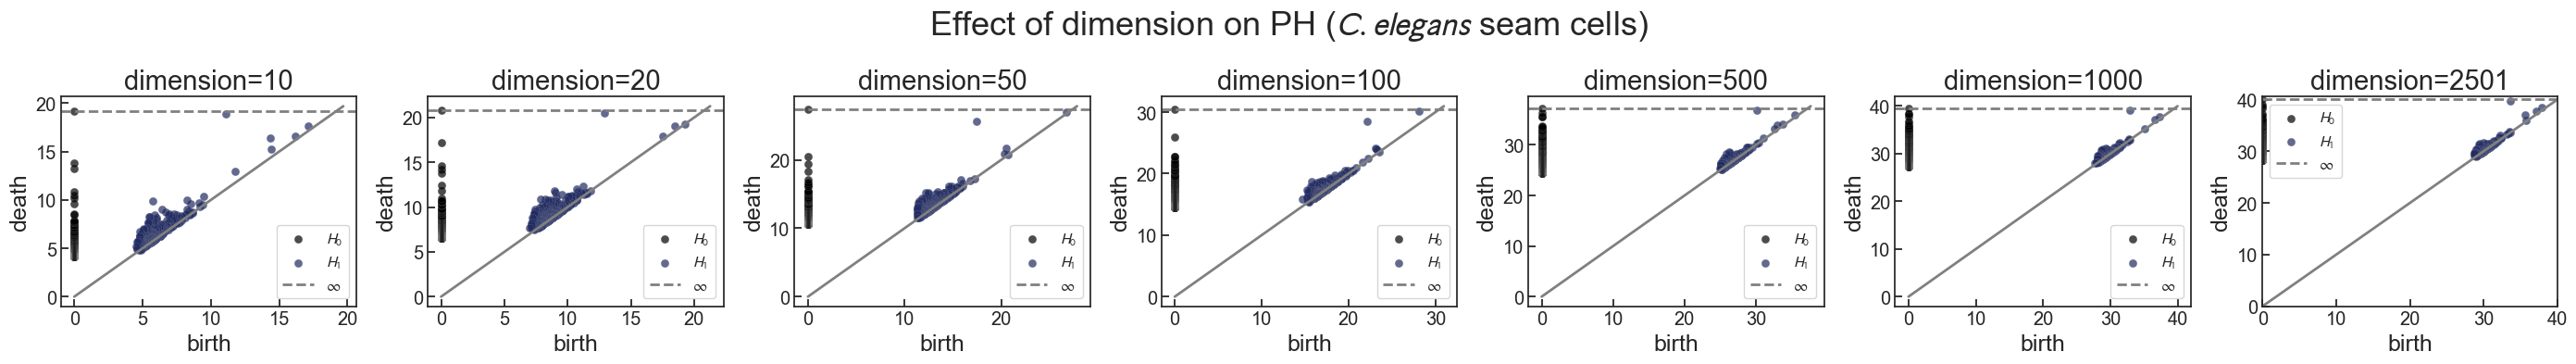

In [57]:
pd_pal = ["#000000","#212b61", ]

# Visualize the persistence diagrams in a grid 
fig, axes = plt.subplots(1, len(dims), figsize=(len(dims)*4, 4))

for i, dim in enumerate(dims[::-1]):
    ax = axes[i]
    dgms = ph_dict[f"{dim}"]["dgms"]
    viz.plot_pers_diag_ripser(dgms, ax=ax,pal=pd_pal)
    ax.set_title(f"dimension={dim}")
    ax.set_xlabel("birth")
    ax.set_ylabel("death")
    ax.legend()

plt.suptitle("Effect of dimension on PH ($C. elegans$ seam cells)", fontsize=26)
plt.subplots_adjust(top=0.8)  # Adjust for suptitle spacing

plt.tight_layout()
plt.savefig(join(fig_dir, "effect_of_dim_on_ph_seam_cells.png"), dpi = 800, bbox_inches= "tight")

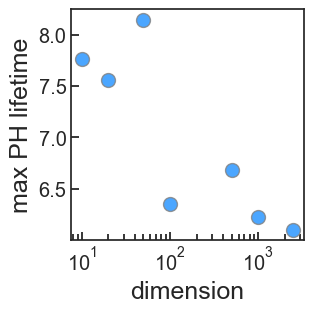

In [58]:
max_lifetimes = []
for dim in dims: 
    dgms=ph_dict[f"{dim}"]["dgms"]
    one_lifetimes = get_lifetimes(dgms[1])
    max_lt = max(one_lifetimes)
    max_lifetimes.append(max_lt)

plt.figure(figsize=(3,3))
plt.scatter(dims, max_lifetimes, edgecolor="grey", color = "dodgerblue", s= 100, alpha=.8)
plt.xscale("log")
plt.xlabel("dimension")
plt.ylabel("max PH lifetime")
plt.savefig(join(fig_dir, "effect_of_dimension_on_max_lifetime_seam_cells.png"), dpi = 800, bbox_inches= "tight")

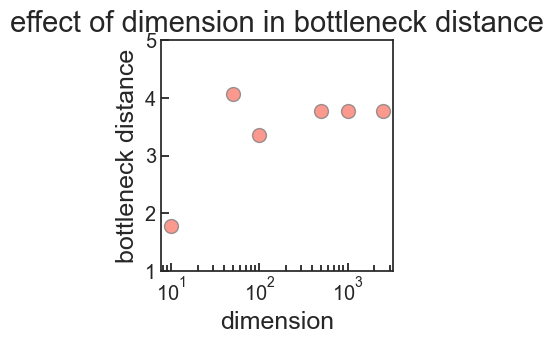

In [42]:
# Plot the bottleneck distances, excluding the pair corresponding to dim=20
filtered_dims = [dim for dim in dims if dim != 20]
filtered_bottleneck_distances = [
    bottleneck_distances[i] for i, dim in enumerate(dims) if dim != 20
]

plt.figure(figsize=(3,3))
plt.scatter(
    filtered_dims,
    filtered_bottleneck_distances,
    edgecolor="grey",
    color="salmon",
    s=100,
    alpha=0.8,
)

plt.xscale("log")
plt.xlabel("dimension")
plt.ylabel("bottleneck distance")
plt.ylim(1,5)
plt.title("effect of dimension in bottleneck distance")
plt.savefig(join(fig_dir, "effect_of_dim_on_bottleneck_dist_seam_cells.png"), dpi = 800, bbox_inches= "tight")

### Simulation

In [11]:
from sklearn.metrics import pairwise_distances
def simulate_noisy_circle_data(n = 1000, d = 50, eta= 1, r = 10):
    
    t = np.random.uniform(0, 2*np.pi, size=n)
    P = np.zeros((n,d),dtype=np.float64)
    P[:, 0], P[:, 1] = r * np.cos(t), r * np.sin(t)
    
    N = np.random.normal(size=(n,d), scale = eta)

    return N + P

In [12]:
n_cells = a.n_obs

In [13]:
pers_dgms2 = {}

In [14]:
eta=1
r=10

In [54]:
a.n_obs

2766

In [15]:
for i, d in tqdm(enumerate(dims)):
    noisy_circle_data = simulate_noisy_circle_data(n = n_cells, d = d, r=10,eta=1)
    pers_dgms2[d] = ripser(noisy_circle_data,n_perm=500)

7it [00:12,  1.77s/it]


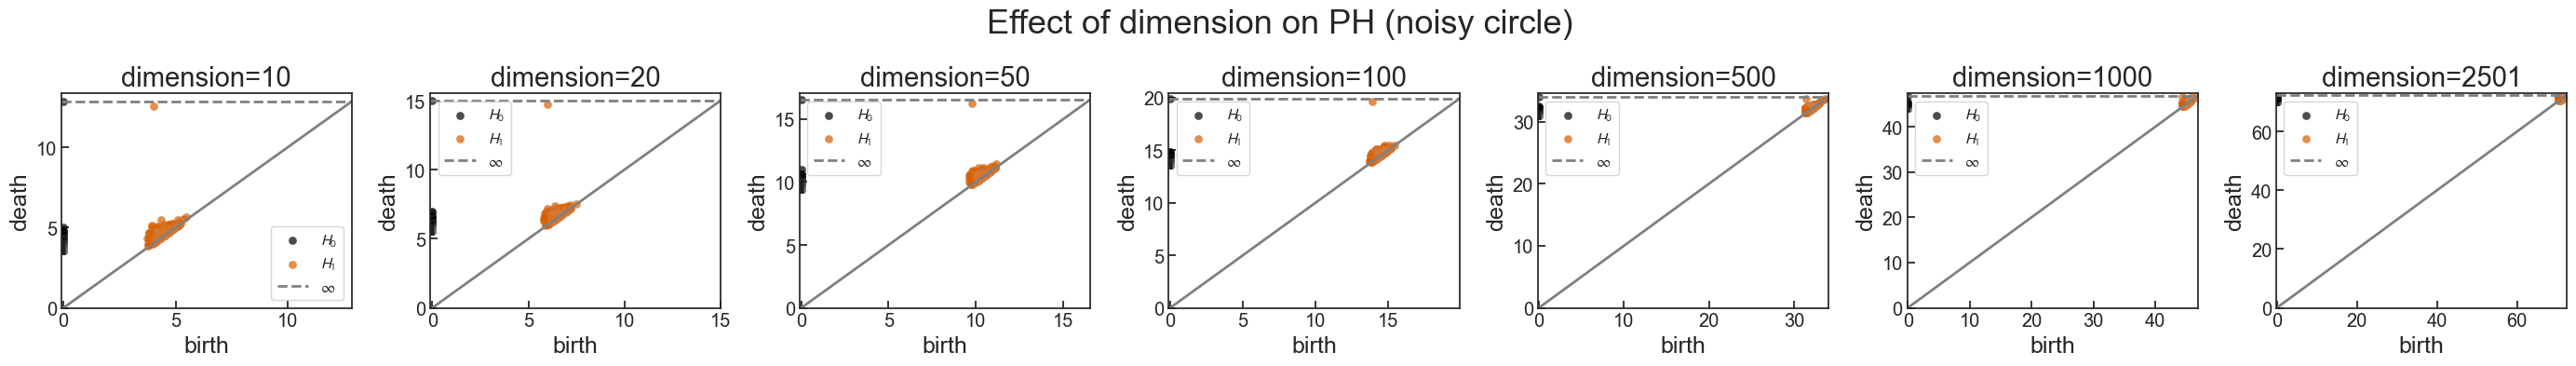

In [52]:
fig = plt.figure(figsize=(4*len(dims), 4))

for i,d in enumerate(dims[::-1]):
    fig.add_subplot(1,len(dims),i+1)
    dgm=pers_dgms2[d]["dgms"]
    viz.plot_pers_diag_ripser(dgm)
    plt.title(f"dimension={d}")

plt.suptitle("Effect of dimension on PH (noisy circle)", fontsize=26)
plt.subplots_adjust(top=0.8)  # Adjust for suptitle spacing
plt.tight_layout()
plt.savefig(join(fig_dir, "effect_of_dim_on_ph_noisy_circle.png"), dpi = 800, bbox_inches= "tight")

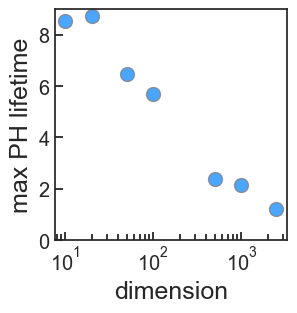

In [51]:
max_lifetimes = []
for dim in dims: 
    dgms=pers_dgms2[dim]["dgms"]
    one_lifetimes = get_lifetimes(dgms[1])
    max_lt = max(one_lifetimes)
    max_lifetimes.append(max_lt)

plt.figure(figsize=(3,3))
plt.scatter(dims, max_lifetimes, edgecolor="grey", color = "dodgerblue", s= 100, alpha=.8)
plt.xscale("log")
plt.xlabel("dimension")
plt.ylabel("max PH lifetime")
plt.ylim(0, 9)
plt.savefig(join(fig_dir, "effect_of_dim_on_max_lifetime_noisy_circle.png"), dpi = 800, bbox_inches= "tight")